<a href="https://colab.research.google.com/github/AnusreeChittineni/VAIL_2021/blob/main/Emotion_Detection_OpenCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D,MaxPooling2D
import os
from google.colab import files
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
# initializes variables to be used throughout code
num_classes=5
img_rows,img_cols=48,48
batch_size=32

#### Import Data

In [ ]:
uploaded = files.upload()

Saving fer2013-20210305T014932Z-001.zip to fer2013-20210305T014932Z-001.zip


In [ ]:
# unzips neccessarry zip files in Drive
# only needs to be run once for your Drive
!unzip -uq "/content/fer2013-20210305T014932Z-001.zip" -d "/content"

In [ ]:
train_data_dir='/content/fer2013/train'
val_data_dir='/content/fer2013/validation'

#### Image Augmentation

In [ ]:
# artificially expands the dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    width_shift_range=0.4,
    height_shift_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# load our dataset from the directory which is augmented
train_generator = train_datagen.flow_from_directory(
 train_data_dir,
 color_mode='grayscale',
 target_size=(img_rows,img_cols),
 batch_size=batch_size,
 class_mode='categorical',
 shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
 val_data_dir,
 color_mode='grayscale',
 target_size=(img_rows,img_cols),
 batch_size=batch_size,
 class_mode='categorical',
 shuffle=True)

Found 24256 images belonging to 5 classes.
Found 3006 images belonging to 5 classes.


#### Define Model

In [ ]:
# initializes model
model = Sequential()

In [ ]:
# defines model layers

#Block-1, input layers
model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal', input_shape=(img_rows,img_cols,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal', input_shape=(img_rows,img_cols,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Block-2-3-4
for size in [64, 128, 256]: 

  model.add(Conv2D(size,(3,3),padding='same',kernel_initializer='he_normal'))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(size,(3,3),padding='same',kernel_initializer='he_normal'))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))

#Block-5
model.add(Flatten())
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#Block-6
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#Block-7, output layers
model.add(Dense(num_classes,kernel_initializer='he_normal'))
model.add(Activation('softmax'))

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0

#### Compile Model

In [ ]:
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
# will monitor the validation loss and will try to minimize the loss
# saves best trained weights
checkpoint = ModelCheckpoint('EmotionDetectionModel.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

# stop the execution early by checking properties
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

# reduces learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)
callbacks = [earlystop,checkpoint,reduce_lr]

In [ ]:
model.compile(loss='categorical_crossentropy',
 optimizer = Adam(lr=0.001),
 metrics=['accuracy'])
nb_train_samples = 24176
nb_validation_samples = 3006
epochs=15

history=model.fit(
 x=train_generator,
 steps_per_epoch=nb_train_samples//batch_size,
 epochs=epochs,
 callbacks=callbacks,
 validation_data=validation_generator,
 validation_steps=nb_validation_samples//batch_size)

Epoch 1/15
755/755 [==============================] - 22s 27ms/step - loss: 1.4662 - accuracy: 0.3592 - val_loss: 1.7421 - val_accuracy: 0.4059

Epoch 00001: val_loss did not improve from 1.52214
Epoch 2/15
755/755 [==============================] - 20s 27ms/step - loss: 1.3518 - accuracy: 0.4277 - val_loss: 1.7715 - val_accuracy: 0.4472

Epoch 00002: val_loss did not improve from 1.52214
Epoch 3/15
755/755 [==============================] - 20s 26ms/step - loss: 1.2762 - accuracy: 0.4668 - val_loss: 1.4192 - val_accuracy: 0.5067

Epoch 00003: val_loss improved from 1.52214 to 1.41918, saving model to EmotionDetectionModel.h5
Epoch 4/15
755/755 [==============================] - 20s 26ms/step - loss: 1.2143 - accuracy: 0.5074 - val_loss: 1.2297 - val_accuracy: 0.5363

Epoch 00004: val_loss improved from 1.41918 to 1.22968, saving model to EmotionDetectionModel.h5
Epoch 5/15
755/755 [==============================] - 20s 27ms/step - loss: 1.1877 - accuracy: 0.5197 - val_loss: 1.2207 - v

#### Driver Code

In [37]:
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [38]:
# load the model and also load a classifier 
face_classifier=cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')
classifier = load_model('/content/EmotionDetectionModel.h5')

In [39]:
class_labels=['Angry','Happy','Neutral','Sad','Surprise']
cap=cv2.VideoCapture(0)

In [40]:
# runs infinitely
while True:
    ret,frame=cap.read()
    labels=[]
    gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces=face_classifier.detectMultiScale(gray,1.3,5)

    for (x,y,w,h) in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray=gray[y:y+h,x:x+w]
        roi_gray=cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)

        if np.sum([roi_gray])!=0:
            roi=roi_gray.astype('float')/255.0
            roi=img_to_array(roi)
            roi=np.expand_dims(roi,axis=0)

            preds=classifier.predict(roi)[0]
            label=class_labels[preds.argmax()]
            label_position=(x,y)
            cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)
        else:
            cv2.putText(frame,'No Face Found',(20,20),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)
    
    cv2.imshow('Emotion Detector',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

error: ignored

In [44]:
uploaded = files.upload()

Saving happy.jpg to happy.jpg


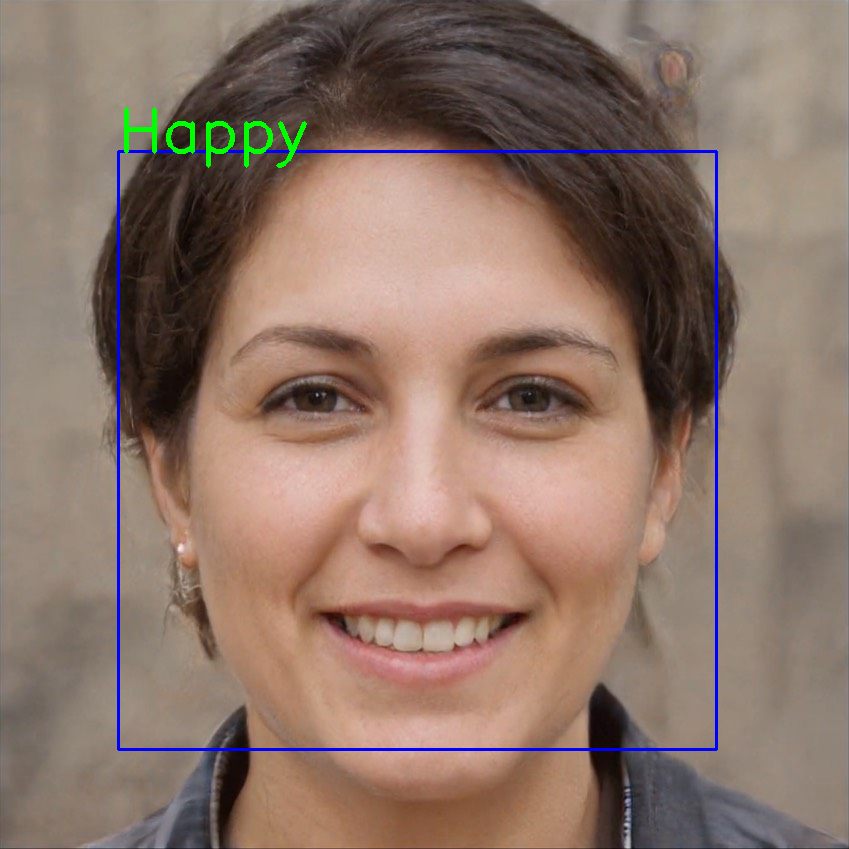

In [45]:
frame = cv2.imread('/content/happy.jpg') 
labels=[]
gray=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
faces=face_classifier.detectMultiScale(gray,1.3,5)

for (x,y,w,h) in faces:
    cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray=gray[y:y+h,x:x+w]
    roi_gray=cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)

    if np.sum([roi_gray])!=0:
        roi=roi_gray.astype('float')/255.0
        roi=img_to_array(roi)
        roi=np.expand_dims(roi,axis=0)

        preds=classifier.predict(roi)[0]
        label=class_labels[preds.argmax()]
        label_position=(x,y)
        cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)
    else:
        cv2.putText(frame,'No Face Found',(20,20),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)

cv2_imshow(frame)